In [1]:
import sys
sys.path.append('../scripts/')
from ideal_robot import *
from scipy.stats import expon, norm, uniform

In [2]:
class Robot(IdealRobot):
    def __init__(self, pose, agent=None, sensor=None, color="black",
                 noise_per_meter=5, noise_std=math.pi / 60, bias_rate_std=0.1,
                 expected_stuck_time=1e100, expected_escape_time=1e-100,
                 expected_kidnap_time=1e100, kidnap_range=(-5.0, 5.0)):
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0 / (1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.position_noise = norm(scale=noise_std)
        self.bias_rate = norm.rvs(loc=1.0, scale=bias_rate_std)

        self.stuck_pdf = expon(scale=expected_stuck_time)
        self.escape_pdf = expon(scale=expected_escape_time)
        self.is_stuck = False
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.time_until_escape = self.escape_pdf.rvs()

        self.kidnap_pdf = expon(scale=expected_kidnap_time)
        self.time_until_kidnap = self.kidnap_pdf.rvs()
        rx = kidnap_range
        self.kidnap_dist = uniform(loc=rx[0], scale=rx[1] - rx[0])

    def noise(self, pose, nu, time_interval):
        self.distance_until_noise -= abs(nu) * time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs()
            pose += self.position_noise.rvs()
        return pose

    def bias(self, nu):
        return nu * self.bias_rate

    def stuck(self, nu, time_interval):
        if self.is_stuck:
            self.time_until_escape -= time_interval
            if self.time_until_escape <= 0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck = False
        else:
            self.time_until_stuck -= time_interval
            if self.time_until_stuck <= 0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck = True

        return nu * (not self.is_stuck)

    def kidnap(self, pose, time_interval):
        self.time_until_kidnap -= time_interval
        if self.time_until_kidnap <= 0.0:
            self.time_until_kidnap += self.kidnap_pdf.rvs()
            return self.kidnap_dist.rvs()
        else:
            return pose

    def one_step(self, time_interval):
        if not self.agent:
            return
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu = self.agent.decision(obs)
        nu = self.bias(nu)
        nu = self.stuck(nu, time_interval)
        self.pose = self.state_transition(nu, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, time_interval)
        self.pose = self.kidnap(self.pose, time_interval)

In [3]:
class Camera(IdealCamera):
    def __init__(self, env_map, distance_range=(0.1, 2.0),
                 distance_noise_rate=0.1, distance_bias_rate_stddev=0.1,
                 phantom_prob=0.0, phantom_range=(-5.0, 5.0),
                 oversight_prob=0.1, occlusion_prob=0.0):
        super().__init__(env_map, distance_range)
        self.distance_noise_rate = distance_noise_rate
        self.distance_bias_rate_std = norm.rvs(scale=distance_bias_rate_stddev)

        rx = phantom_range
        self.phantom_dist = uniform(loc=rx[0], scale=rx[1] - rx[0])
        self.phantom_prob = phantom_prob

        self.oversight_prob = oversight_prob
        self.occlusion_prob = occlusion_prob

    def noise(self, distance):
        return norm.rvs(loc=distance, scale=distance * self.distance_noise_rate)

    def bias(self, distance):
        return distance + distance * self.distance_bias_rate_std

    def phantom(self, distance):
        if uniform.rvs() < self.phantom_prob:
            return self.phantom_dist.rvs()
        else:
            return distance

    def oversight(self, distance):
        if uniform.rvs() < self.oversight_prob:
            return None
        else:
            return distance

    def occlusion(self, distance):
        if uniform.rvs() < self.occlusion_prob:
            return distance + uniform.rvs() * (self.distance_range[1] - distance)
        else:
            return distance

    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            distance = self.observation_function(cam_pose, lm.pos)
            distance = self.phantom(distance)
            distance = self.occlusion(distance)
            distance = self.oversight(distance)
            if self.visible(distance):
                distance = self.bias(distance)
                distance = self.noise(distance)
                observed.append((distance, lm.id))
        self.lastdata = observed
        return observed

<IPython.core.display.Javascript object>


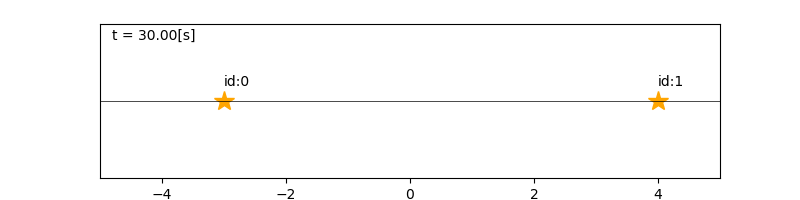

In [4]:
if __name__ == '__main__':
    world = World(30, 0.1, debug=False)

    m = Map()
    m.append_landmark(Landmark(-3))
    m.append_landmark(Landmark(4))
    world.append(m)

    straight = Agent(0.4)
    r = Robot(-5, sensor=Camera(m, occlusion_prob=0.1), agent=straight)
    world.append(r)

    world.draw()